In [1]:
import numpy as np

from matplotlib import pyplot as plt

import ot

from typing import Dict
from numpy import typing as npt
from sys import stderr

In [2]:
def read_chains(filename: str) -> Dict[str, npt.NDArray]:
    try:
        with open(filename, "r") as f:
            chains = dict()
            for line in f.readlines():
                name, *data = line.split()
                chains[name] = np.array(list(map(float, data)))
            return chains
    except IOError as e:
        print(f"{e}", file=stderr)
        return dict()

In [3]:
chains_no_hc = read_chains("../simpson_no_hc_chains.txt")

In [4]:
NUM_HYPERCUBES = 6

chains_hc = [read_chains(f"../simpson_chains_hc_{i}.txt") for i in range(NUM_HYPERCUBES)]

In [5]:
chains_hc_comb = {key: np.concatenate([chain[key] for chain in chains_hc]) for key in chains_hc[0]}

In [6]:
with open("../../benchmarks/data/simpson/test_data.txt", "r") as f:
    x_data = np.array(list(map(float, f.readline().split())))
    y_data = np.array(list(map(float, f.readline().split())))

In [7]:
def generate_data(chain, n, x_low, x_high):
    assert chain['theta0'].shape == chain['theta1'].shape
    assert chain['theta0'].shape == chain['log_posterior'].shape
    idxs = np.random.randint(0, chain['theta0'].shape[0] + 1, n)
    xs = np.random.uniform(x_low, x_high, n)
    ys = np.zeros_like(xs)

    for i, (idx, x) in enumerate(zip(idxs, xs)):
        ys[i] = chain['theta0'][idx] * x + chain['theta1'][idx]

    return xs, ys

In [8]:
assert x_data.shape == y_data.shape
n = x_data.shape[0]
x_low = np.min(x_data)
x_high = np.max(x_data)

xs_no_hc, ys_no_hc = generate_data(chains_no_hc, n, x_low, x_high)

xs_with_hc, ys_with_hc = generate_data(chains_hc_comb, n, x_low, x_high)

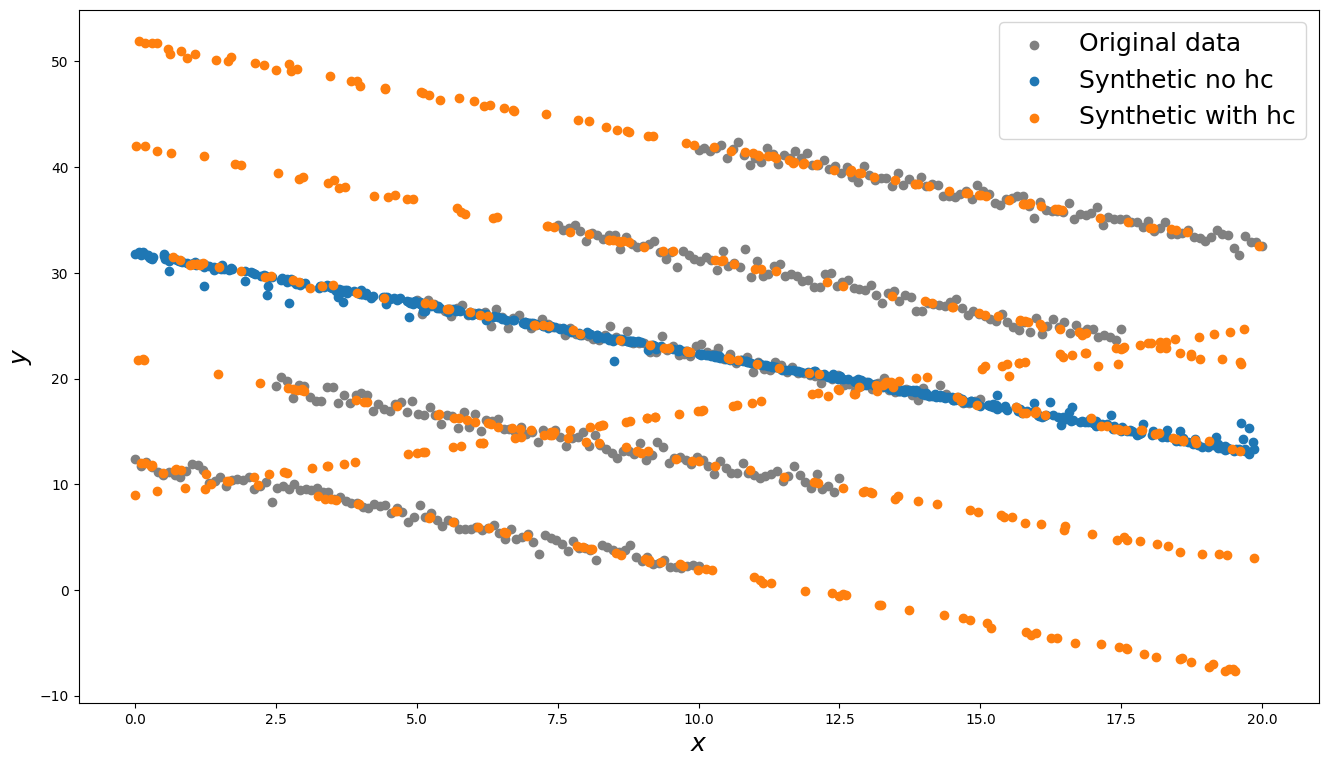

In [9]:
plt.figure(figsize=(16, 9))

plt.scatter(x_data, y_data, label="Original data", color="grey")

plt.scatter(xs_no_hc, ys_no_hc, label="Synthetic no hc")

plt.scatter(xs_with_hc, ys_with_hc, label="Synthetic with hc")

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.legend(fontsize=18)


plt.show()

In [10]:
orig_data    = np.array([x_data, y_data]).T
no_hc_data   = np.array([xs_no_hc, ys_no_hc]).T
with_hc_data = np.array([xs_with_hc, ys_with_hc]).T

In [11]:
sws_dist_no_hc = ot.sliced_wasserstein_distance(X_s=no_hc_data, X_t=orig_data, n_projections=100)
print(f"Sliced Wasserstein distance no hc: {sws_dist_no_hc}")

Sliced Wasserstein distance no hc: 5.80289607305946


In [12]:
sws_dist_with_hc = ot.sliced_wasserstein_distance(X_s=with_hc_data, X_t=orig_data, n_projections=100)
print(f"Sliced Wasserstein distance with hc: {sws_dist_with_hc}")

Sliced Wasserstein distance with hc: 3.52156857762688


In [13]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [14]:
d = cdist(orig_data, no_hc_data)
assignment = linear_sum_assignment(d)
print(f"Distance no hc: {d[assignment].sum() / n}")

Distance no hc: 8.76284821808109


In [15]:
d = cdist(orig_data, with_hc_data)
assignment = linear_sum_assignment(d)
print(f"Distance with hc: {d[assignment].sum() / n}")

Distance with hc: 4.818830222818239
